# Сравнение средних значений: Дисперсионный анализ

На практике количество групп часто превышает две, и с этой ситуацией t-критерий не справляется. Научимся проводить дисперсионный анализ, который применяется именно в таких случаях.

In [42]:
import pandas as pd
import numpy as np

import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(16,6)}, style="whitegrid")

In [2]:
#грузим первые данные

post_likes = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-eremina/statistics/post_likes.csv')

In [3]:
post_likes.head()

,id,button,likes
0,S001,red,160
1,S002,red,150
2,S003,red,150
3,S004,red,150
4,S005,red,187


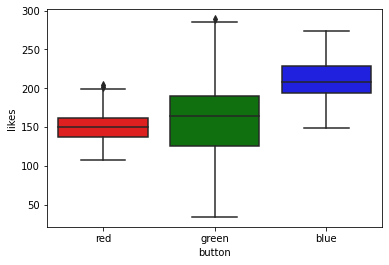

In [4]:
#боксплот

sns.boxplot(x="button", y="likes", data=post_likes, palette=["r", "g", "b"])

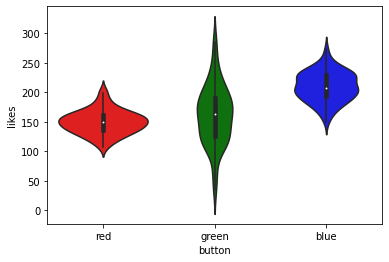

In [5]:
#скрипичный график

sns.violinplot(x="button", y="likes", data=post_likes, palette=["r", "g", "b"])

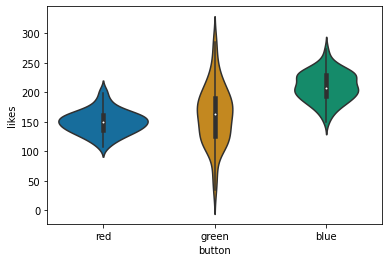

In [6]:
#для студентов с цветовой слепотой

sns.violinplot(x="button", y="likes", data=post_likes, palette="colorblind")

Три способа посчитать однофакторный ANOVA:

In [7]:
#через scipy

red = post_likes.query("button == 'red'").likes
green = post_likes.query("button == 'green'").likes
blue = post_likes.query("button == 'blue'").likes

In [8]:
ss.f_oneway(red, green, blue)

F_onewayResult(statistic=85.99631112614011, pvalue=3.4370045810218544e-30)

In [9]:
#через statsmodels

model = smf.ols(formula = "likes ~ C(button)", data = post_likes).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(button),2.0,201960.286667,100980.143333,85.996311,3.437005e-30
Residual,297.0,348748.710000,1174.238081,NaN,NaN


In [10]:
#через pingouin

pg.anova(data=post_likes, dv="likes", between="button")

,Source,ddof1,ddof2,F,p-unc,np2
0,button,2,297,85.996311,3.437005e-30,0.366728


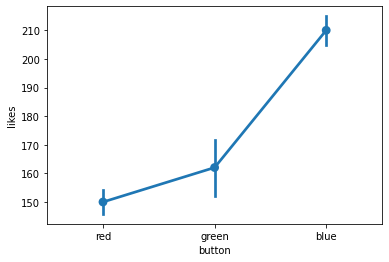

In [11]:
#средние с доверительными интервалами

sns.pointplot(x="button", y="likes", data=post_likes)

Тестируем нормальность:

In [12]:
#через scipy 

print(ss.shapiro(red))
print(ss.shapiro(blue))
print(ss.shapiro(green))

ShapiroResult(statistic=0.988104522228241, pvalue=0.515945315361023)
ShapiroResult(statistic=0.9937936663627625, pvalue=0.9309920072555542)
ShapiroResult(statistic=0.9887180328369141, pvalue=0.5625539422035217)


In [13]:
#другой вариант

print(ss.normaltest(red))
print(ss.normaltest(blue))
print(ss.normaltest(green))

NormaltestResult(statistic=1.8343585907539965, pvalue=0.3996447324611219)
NormaltestResult(statistic=0.4606964500747045, pvalue=0.7942569741771747)
NormaltestResult(statistic=0.6727062715909409, pvalue=0.7143707913703767)


In [14]:
#через pingouin

pg.normality(data=post_likes, dv="likes", group="button", method="normaltest")

,W,pval,normal
red,1.834359,0.399645,True
green,0.672706,0.714371,True
blue,0.460696,0.794257,True


Можно квантиль-квантиль графики:

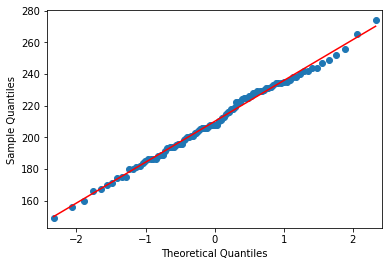

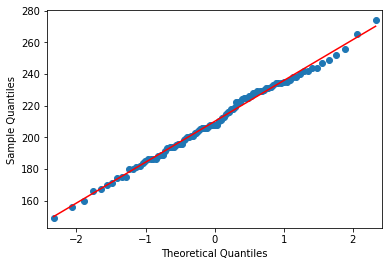

In [15]:
sm.qqplot(blue, line="r")

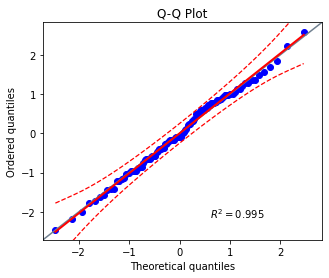

In [16]:
pg.qqplot(blue)

Тестируем различие в дисперсиях:

In [17]:
#через scipy

ss.levene(red, green, blue)

LeveneResult(statistic=35.214282435572876, pvalue=1.8886636651084242e-14)

In [18]:
#через pingouin

pg.homoscedasticity(data=post_likes, dv="likes", group="button")

,W,pval,equal_var
levene,35.214282,1.888664e-14,False


In [19]:
#anova Уэлча в pingouin

pg.welch_anova(data=post_likes, dv="likes", between="button")

,Source,ddof1,ddof2,F,p-unc,np2
0,button,2,182.958104,177.856578,1.255660e-43,0.366728


#### Множественные сравнения

In [20]:
#попарные сравнения без поправки
pg.pairwise_ttests(data=post_likes, dv="likes", between="button")

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,button,blue,green,False,True,8.591097,198.0,two-sided,2.561866e-15,2.025e+12,1.210357
1,button,blue,red,False,True,18.769214,198.0,two-sided,7.952330e-46,1.582e+42,2.644301
2,button,green,red,False,True,2.240189,198.0,two-sided,2.619001e-02,1.583,0.315609


In [21]:
#с поправкой Бонферрони
pg.pairwise_ttests(data=post_likes, dv="likes", between="button", padjust="holm")

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,button,blue,green,False,True,8.591097,198.0,two-sided,2.561866e-15,5.123733e-15,holm,2.025e+12,1.210357
1,button,blue,red,False,True,18.769214,198.0,two-sided,7.952330e-46,2.385699e-45,holm,1.582e+42,2.644301
2,button,green,red,False,True,2.240189,198.0,two-sided,2.619001e-02,2.619001e-02,holm,1.583,0.315609


In [22]:
#тьюки

pg.pairwise_tukey(data=post_likes, dv="likes", between="button")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,blue,green,210.03,162.02,48.01,4.846108,9.906919,0.001000,1.395736
1,blue,red,210.03,149.96,60.07,4.846108,12.395514,0.001000,1.746342
2,green,red,162.02,149.96,12.06,4.846108,2.488595,0.035581,0.350606


In [23]:
#геймс-хоувелл

pg.pairwise_gameshowell(data=post_likes, dv="likes", between="button")

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,blue,green,210.03,162.02,48.01,5.588343,8.591097,145.583529,0.001000,1.210357
1,blue,red,210.03,149.96,60.07,3.200454,18.769214,188.902921,0.001000,2.644301
2,green,red,162.02,149.96,12.06,5.383475,2.240189,129.889834,0.068387,0.315609


In [24]:
pairwise_tukeyhsd(post_likes.likes, post_likes.button).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
blue,green,-48.01,0.001,-59.4257,-36.5943,True
blue,red,-60.07,0.001,-71.4857,-48.6543,True
green,red,-12.06,0.0356,-23.4757,-0.6443,True


In [25]:
MultiComparison(post_likes.likes, post_likes.button).tukeyhsd().summary()

group1,group2,meandiff,p-adj,lower,upper,reject
blue,green,-48.01,0.001,-59.4257,-36.5943,True
blue,red,-60.07,0.001,-71.4857,-48.6543,True
green,red,-12.06,0.0356,-23.4757,-0.6443,True


#### Многофакторный ANOVA

In [26]:
#грузим многофакторные данные

ads_clicks = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-eremina/statistics/ads_clicks.csv')

In [27]:
ads_clicks.head()

,id,ads,age_group,clicks
0,S001,classic,18-27,40
1,S002,classic,18-27,22
2,S003,classic,18-27,41
3,S004,classic,18-27,35
4,S005,classic,18-27,39


In [28]:
#через statsmodels, только главные эффекты

model_main = smf.ols("clicks ~ C(ads) + C(age_group)", data=ads_clicks).fit()
anova_lm(model_main)

,df,sum_sq,mean_sq,F,PR(>F)
C(ads),1.0,33735.001667,33735.001667,68.810244,7.245176e-16
C(age_group),2.0,400495.163333,200247.581667,408.450696,1.950084e-112
Residual,596.0,292195.753333,490.261331,NaN,NaN


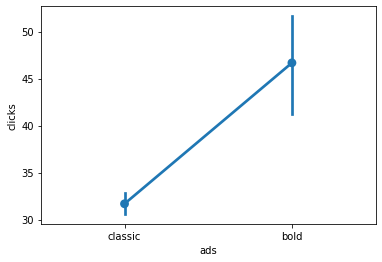

In [29]:
#первый фактор

sns.pointplot(x="ads", y="clicks", data=ads_clicks)

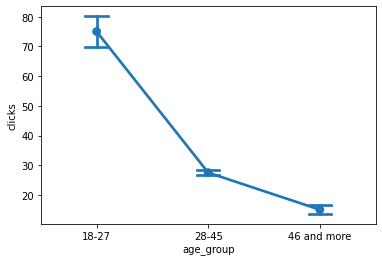

In [30]:
#второй фактор

sns.pointplot(x="age_group", y="clicks", data=ads_clicks, capsize=0.2)

In [31]:
#взаимодействие

model_interact = smf.ols("clicks ~ C(ads)*C(age_group)", data=ads_clicks).fit()
anova_lm(model_interact)

,df,sum_sq,mean_sq,F,PR(>F)
C(ads),1.0,33735.001667,33735.001667,336.722432,6.446773e-60
C(age_group),2.0,400495.163333,200247.581667,1998.750536,1.636934e-264
C(ads):C(age_group),2.0,232685.043333,116342.521667,1161.260853,5.618312e-206
Residual,594.0,59510.710000,100.186380,NaN,NaN


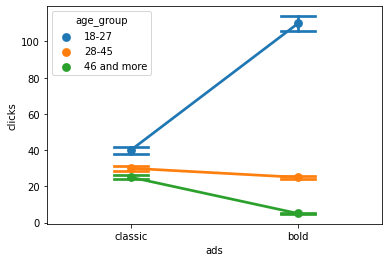

In [32]:
#взаимодействие

sns.pointplot(x="ads", y="clicks", hue="age_group", data=ads_clicks, capsize=0.2)

In [33]:
#теперь pingouin

pg.anova(data=ads_clicks, dv="clicks", between=["ads", "age_group"])

,Source,SS,DF,MS,F,p-unc,np2
0,ads,33735.001667,1,33735.001667,336.722432,6.446773e-60,0.361786
1,age_group,400495.163333,2,200247.581667,1998.750536,1.636934e-264,0.870631
2,ads * age_group,232685.043333,2,116342.521667,1161.260853,5.618312e-206,0.796333
3,Residual,59510.710000,594,100.186380,NaN,NaN,NaN


In [34]:
#размер эффекта

pg.anova(data=ads_clicks, dv="clicks", between=["ads", "age_group"], effsize="n2")

,Source,SS,DF,MS,F,p-unc,n2
0,ads,33735.001667,1,33735.001667,336.722432,6.446773e-60,0.046440
1,age_group,400495.163333,2,200247.581667,1998.750536,1.636934e-264,0.551323
2,ads * age_group,232685.043333,2,116342.521667,1161.260853,5.618312e-206,0.320315
3,Residual,59510.710000,594,100.186380,NaN,NaN,NaN


In [35]:
#тип суммы квадратов

pg.anova(data=ads_clicks, dv="clicks", between=["ads", "age_group"], ss_type=2)

,Source,SS,DF,MS,F,p-unc,np2
0,ads,33735.001667,1,33735.001667,336.722432,6.446773e-60,0.361786
1,age_group,400495.163333,2,200247.581667,1998.750536,1.636934e-264,0.870631
2,ads * age_group,232685.043333,2,116342.521667,1161.260853,5.618312e-206,0.796333
3,Residual,59510.710000,594,100.186380,NaN,NaN,NaN


In [36]:
dat_unbalanced = ads_clicks.query("id != 'S001'")

In [37]:
dat_unbalanced.head()

,id,ads,age_group,clicks
1,S002,classic,18-27,22
2,S003,classic,18-27,41
3,S004,classic,18-27,35
4,S005,classic,18-27,39
5,S006,classic,18-27,35


In [38]:
pg.anova(data=dat_unbalanced, dv="clicks", between=["ads", "age_group"], ss_type=1)

,Source,SS,DF,MS,F,p-unc,np2
0,ads,33803.779316,1.0,33803.779316,336.840901,6.486330e-60,0.362256
1,age_group,401187.127208,2.0,200593.563604,1998.833209,2.914479e-264,0.870825
2,ads * age_group,231923.625646,2.0,115961.812823,1155.512262,2.698570e-205,0.795801
3,Residual,59510.709899,593.0,100.355329,NaN,NaN,NaN


In [39]:
pg.anova(data=dat_unbalanced, dv="clicks", between=["age_group", "ads"], ss_type=3)

,Source,SS,DF,MS,F,p-unc,np2
0,age_group,399202.638264,2.0,199601.319132,1988.945896,1.048185e-263,0.870266
1,ads,33678.455412,1.0,33678.455412,335.592099,9.673077e-60,0.361399
2,age_group * ads,231923.625646,2.0,115961.812823,1155.512262,2.698570e-205,0.795801
3,Residual,59510.709899,593.0,100.355329,NaN,NaN,NaN


### Однофакторный дисперсионный анализ

    from scipy import stats 
    stats.f_oneway(a, b, c) # a, b, c - переменные с данными трёх групп

либо

    import statsmodels.formula.api as smf 
    model = smf.ols(formula = "зависимая_переменная ~ независимая_переменная)", data = данные).fit() 
    anova_lm(model)

либо

    import pingouin as pg
    pg.anova(data=данные, dv="зависимая_переменная", between="независимая_переменная")

Важный новый элемент - размер эффекта. 
Он указывает, какой процент всей изменчивости в данных объясняется нашим экспериментальным воздействием.

Если группы не обладают равной дисперсией, то можно сделать **дисперсионный анализ Уэлча:**

    pg.welch_anova(data=данные, dv="зависимая_переменная", between="независимая_переменная")

In [41]:
# Независимые парные Т-тесты

# df.ptests()
#         N       E      O      A    C
# N       -     ***    ***    ***  ***
# E  -8.397       -                ***
# O  -8.332  -0.596      -         ***
# A  -8.804    0.12   0.72      -  ***
# C  -4.759   3.753  4.074  3.787    -

# Давайте сравним со SciPy

# from scipy.stats import ttest_ind
# np.round(ttest_ind(df["N"], df["E"]), 3)
# array([-8.397,  0.   ])
# scipy.stats.ttest_ind()Передача пользовательских параметров в функцию нижнего уровня

# df.ptests(alternative="greater", equal_var=True)
#         N       E      O      A    C
# N       -
# E  -8.397       -                ***
# O  -8.332  -0.596      -         ***
# A  -8.804    0.12   0.72      -  ***
# C  -4.759   3.753  4.074  3.787    -
# Парный Т-тест, показывающий фактические значения p вместо звездочек

# df.ptests(paired=True, stars=False, decimals=4)
#         N        E       O       A       C
# N        -   0.0000  0.0000  0.0000  0.0002
# E  -7.0773        -  0.8776  0.7522  0.0012
# O  -8.0568  -0.1555       -  0.8137  0.0008
# A  -8.3994   0.3191  0.2383       -  0.0009
# C  -4.2511   3.5953  3.7849  3.7652       -
# Корректировка на множественные сравнения с использованием метода Холма-Бонферрони

# df.ptests(paired=True, stars=False, padjust="holm")
#         N       E      O      A      C
# N       -   0.000  0.000  0.000  0.001
# E  -7.077       -     1.     1.  0.005
# O  -8.057  -0.155      -     1.  0.005
# A  -8.399   0.319  0.238      -  0.005
# C  -4.251   3.595  3.785  3.765      -

**Критерий Тьюки в Python:**

    from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                             MultiComparison)
    print(pairwise_tukeyhsd(столбец_с_данными, столбец_с_обозначениями_групп))

или

    MultiComp = MultiComparison(столбец_с_данными, столбец_с_обозначениями_групп)
    print(MultiComp.tukeyhsd().summary())

- group1 и group2 — названия групп, которые сравниваются в рамках теста
- meandiff — разница между значением 2 группы и значением 1 группы
- p-adj — скорректированный порог значимости
- lower и upper — нижняя и верхняя границы доверительного интервала различий в средних
- reject — отвергается нулевая гипотеза или нет

Если мы используем функцию из pingouin:

    pg.pairwise_tukey(data=данные, dv="зависимая_переменная", between="независимая_переменная")

Дополнительный элемент - стандартизованная разница в средних под названием Hedges G.

Если наши группы имеют разную дисперсию, то применяется критерий Геймса-Хоувелла:

    pg.pairwise_gameshowell(data=данные, dv="зависимая_переменная", between="независимая_переменная")


### Многофакторный дисперсионный анализ

    from statsmodels.formula.api import ols
    from statsmodels.stats.anova import anova_lm

    formula = 'зависимая_переменная ~ фактор1 + фактор2 + фактор1:фактор2'
    model = ols(formula, data).fit()
    aov_table = anova_lm(model, typ=2)

Через pingouin:

    pg.anova(data=данные, dv="зависимая_переменная", between=["фактор1", "фактор2"])

Визуализация:

    sns.pointplot(x = 'dose', y = 'len', hue = 'supp', data = teeth, capsize = .2)
    plt.title('Длина зубов морской свинки в зависимости от дозы и типа препарата')
    plt.xlabel('Доза препарата')
    plt.ylabel('Длина зубов')
    plt.legend(title = 'Тип препарата')

# ПРОЕКТ

На этот раз ситуация следующая: вы работаете в приложении по доставке готовых продуктов. К вам пришел коллега с результатами двух тестов:

- В первом тестировали разрешение фотографий блюд в приложении: пользователям показывались либо прямоугольные, либо новые квадратные 
- Во втором: была обновлена кнопка заказа, и часть юзеров видела старый вариант, а часть – новый

Коллега пришел к вам с просьбой: он посмотрел на графики и предположил, что среди групп могут встретиться различия. Ваша задача – помочь ему проверить гипотезы, сделать соответствующие выводы на основе статистических тестов и принять решения.

### Описание данных

*5_task_1*:

- id – id клиента в эксперименте
- group – в каком разрешении показывались картинки (A – прямоугольные 16:9, B – квадратные, C – прямоугольные 12:4)
- events – сколько блюд суммарно было заказано за период

*5_task_2*:

- id – id клиента в эксперименте
- segment – сегмент (high/low)
- group – вид кнопки (control – старая версия, test – новая версия)
- events – сколько блюд суммарно было заказано за период

In [43]:
task_1 = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-eremina/statistics/5_task_1.csv')
task_2 = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-eremina/statistics/5_task_2.csv')

Итак, первая задача: нужно проверить, какой формат фотографий блюд является наилучшим, т.е. в какой из групп в среднем покупали больше всего. Всего пользователям показывались три варианта:

- A – прямоугольные 16:9
- B – квадратные
- C – прямоугольные 12:4

Каким статистическим тестом нужно воспользоваться для сравнения средних в данном случае?

- t-test
- **ANOVA** (потому что три группы)
- посчитаю хи-квадрат
- посмотрю только по графику

In [44]:
task_1.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


In [45]:
task_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      30000 non-null  int64 
 1   group   30000 non-null  object
 2   events  30000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 703.2+ KB


Проверьте, являются ли дисперсии внутри групп примерно одинаковыми (гомогенными) с помощью теста Левена.

In [46]:
ss.levene(task_1.query('group == "A"').events, task_1.query('group == "B"').events, task_1.query('group == "C"').events)


LeveneResult(statistic=2.2622596339318037, pvalue=0.1041327199523974)

In [47]:
pg.homoscedasticity(data=task_1,dv='events', group='group')

,W,pval,equal_var
levene,2.26226,0.104133,True


- **p-value > 0.05, не отклоняем нулевую гипотезу**
- p-value > 0.05, отклоняем нулевую гипотезу
- p-value < 0.05, не отклоняем нулевую гипотезу
- p-value < 0.05, отклоняем нулевую гипотезу

Также убедитесь, что данные распределены нормально, применив тест **Шапиро-Уилка**. Перед применением критерия при проверке на нормальность обязательно сделайте семплирование, так как на больших выборках вы можете получать неверные результаты. Для воспроизводимости результата используйте параметр random_state=17 в методе sample.


In [48]:
ss.normaltest(task_1.query('group == "A"').events)

NormaltestResult(statistic=2.1034599402238734, pvalue=0.3493328906085719)

In [49]:
ss.normaltest(task_1.query('group == "B"').events)

NormaltestResult(statistic=0.8410715800223014, pvalue=0.6566948749848232)

In [50]:
ss.normaltest(task_1.query('group == "C"').events)

NormaltestResult(statistic=3.243725809054571, pvalue=0.19753037588314626)

In [51]:
pg.normality(data=task_1,dv='events', group='group', method='shapiro') 
# слишком чувствительный при большом количестве наблюдений


/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,W,pval,normal
A,0.998942,0.000004,False
B,0.999016,0.000011,False
C,0.998921,0.000003,False


In [52]:
pg.normality(data=task_1,dv='events', group='group', method='normaltest')

,W,pval,normal
A,2.103460,0.349333,True
B,0.841072,0.656695,True
C,3.243726,0.197530,True


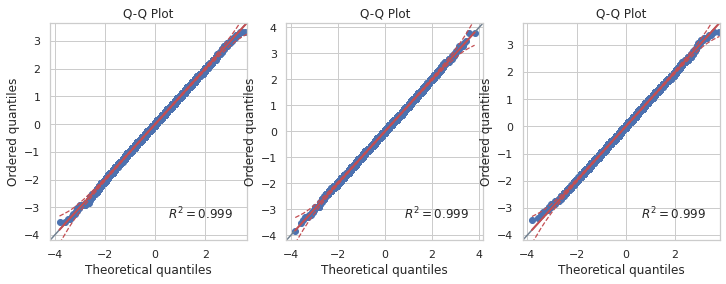

In [53]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1 = pg.qqplot(task_1.query('group == "A"').events, ax = ax1, dist='norm')
ax2 = pg.qqplot(task_1.query('group == "B"').events, ax = ax2, dist='norm')
ax3 = pg.qqplot(task_1.query('group == "C"').events, ax = ax3, dist='norm')

Самое время провести тест! Однофакторный дисперсионный анализ:

In [54]:
ss.f_oneway(task_1.query('group == "A"').events, task_1.query('group == "B"').events, task_1.query('group == "C"').events) 

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)

In [55]:
pg.anova(data=task_1, dv='events', between='group')

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,29997,2886.166657,0.0,0.161377


Теперь используйте критерий Тьюки и определите, между какими группами есть статистически значимые различия. 

Дополнительно: попробуйте другие варианты поправок на множественные сравнения через pingouin. 

In [56]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

pairwise_tukeyhsd(task_1.events, task_1.group).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,8.034,0.001,7.7038,8.3642,True
A,C,-2.1093,0.001,-2.4395,-1.7791,True
B,C,-10.1433,0.001,-10.4735,-9.8131,True


In [57]:
pg.pairwise_tukey(data=task_1, dv="events", between="group")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140894,-57.021604,0.001,-0.806377
1,A,C,29.5796,27.4703,2.1093,0.140894,14.970833,0.001,0.211712
2,B,C,37.6136,27.4703,10.1433,0.140894,71.992436,0.001,1.018089


Text(0, 0.5, 'Число покупок')

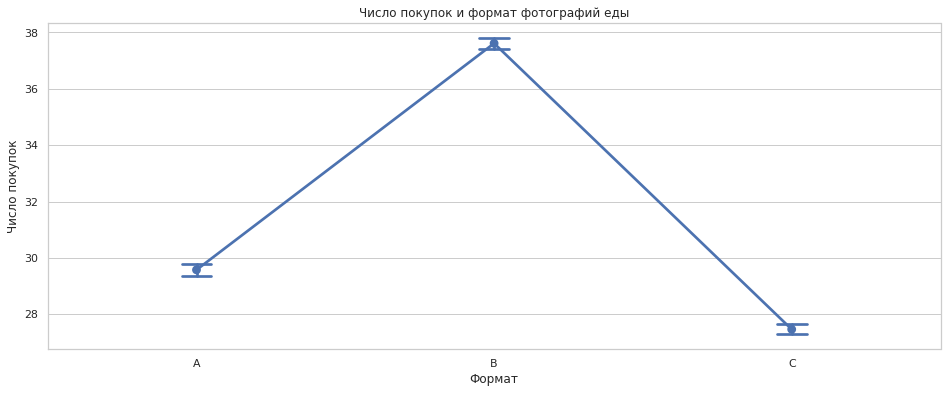

In [58]:
sns.pointplot(x='group', y='events', data=task_1, capsize=0.1)
plt.title('Число покупок и формат фотографий еды')
plt.xlabel('Формат')
plt.ylabel('Число покупок')

In [62]:
pg.pairwise_ttests(data=task_1,dv='events', between = 'group', padjust = 'bonf')

/opt/tljh/user/lib/python3.7/site-packages/pingouin/bayesian.py:146: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df)**(-(df + 1) / 2) / integr)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,group,A,B,False,True,-57.011134,19998.0,two-sided,0.000000e+00,0.000000e+00,bonf,inf,-0.806229
1,group,A,C,False,True,14.886135,19998.0,two-sided,7.500262e-50,2.250078e-49,bonf,1.054e+46,0.210514
2,group,B,C,False,True,72.420220,19998.0,two-sided,0.000000e+00,0.000000e+00,bonf,inf,1.024138


In [63]:
pg.pairwise_gameshowell(data=task_1, dv="events", between="group")

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140920,-57.011134,19987.258491,0.001,-0.806229
1,A,C,29.5796,27.4703,2.1093,0.141696,14.886135,19995.116233,0.001,0.210514
2,B,C,37.6136,27.4703,10.1433,0.140062,72.420220,19995.502469,0.001,1.024138


Так какие картинки в итоге будем использовать?

- **B – квадратные**, потому что среднее наибольшее и статистически значимо отличается от A & C

Во втором эксперименте требуется проверить, как пользователи отреагируют на изменение формата кнопки оформления заказа, 
с разбивкой по сегменту клиента.

Какой метод скорее всего пригодится в данном случае?

- **многофакторный дисперсионный анализ**

Посмотрим на данные. Для начала визуализируйте распределение events для контрольной и тестовой групп. 

In [64]:
task_2.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


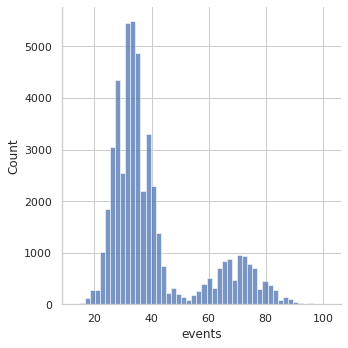

In [70]:
sns.displot(data=task_2.query('group == "test"'), x = 'events', bins=50)

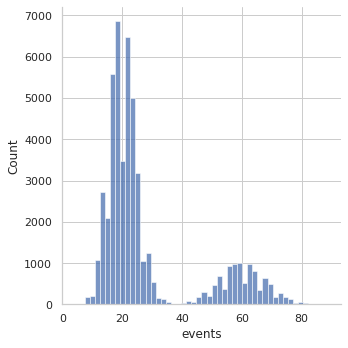

In [71]:
sns.displot(data=task_2.query('group == "control"'), x = 'events', bins=50)

Посчитайте среднее, медиану и стандартное отклонение events в разбивке по группе и по сегменту пользователя. 

In [72]:
task_2.groupby(['group', 'segment']).events.describe()

count       mean       std   min   25%   50%   75%    max
group   segment                                                             
control high     10000.0  59.970800  7.805347  31.0  55.0  60.0  65.0   89.0
        low      40000.0  20.031575  4.473576   4.0  17.0  20.0  23.0   41.0
test    high     10000.0  69.938500  8.403974  40.0  64.0  70.0  76.0  102.0
        low      40000.0  33.025925  5.720845  13.0  29.0  33.0  37.0   59.0

In [73]:
task_2.groupby(['group', 'segment']).agg({'events':['mean','median','std']}).round(2)

events             
                  mean median   std
group   segment                    
control high     59.97   60.0  7.81
        low      20.03   20.0  4.47
test    high     69.94   70.0  8.40
        low      33.03   33.0  5.72

In [74]:
task_2.query('group == "control" and segment == "high"').events.std().round(2)

7.81

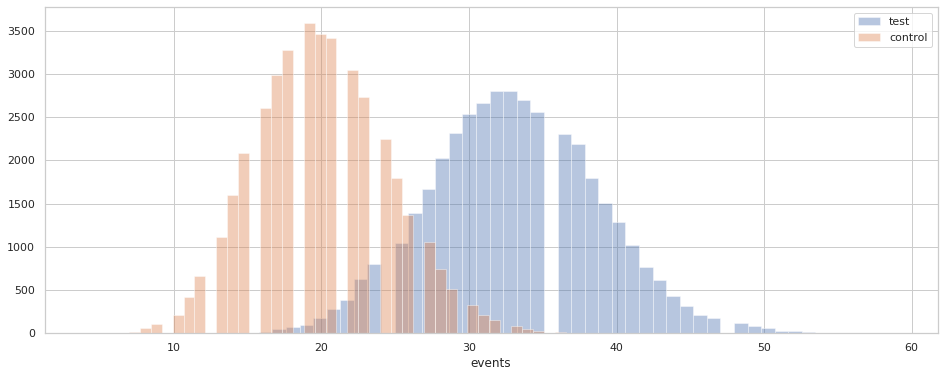

In [76]:
sns.distplot(task_2.query("segment == 'low' & group=='test'").events, label='test', kde=False)
sns.distplot(task_2.query("segment == 'low' & group=='control'").events, label='control', kde=False)
plt.legend()

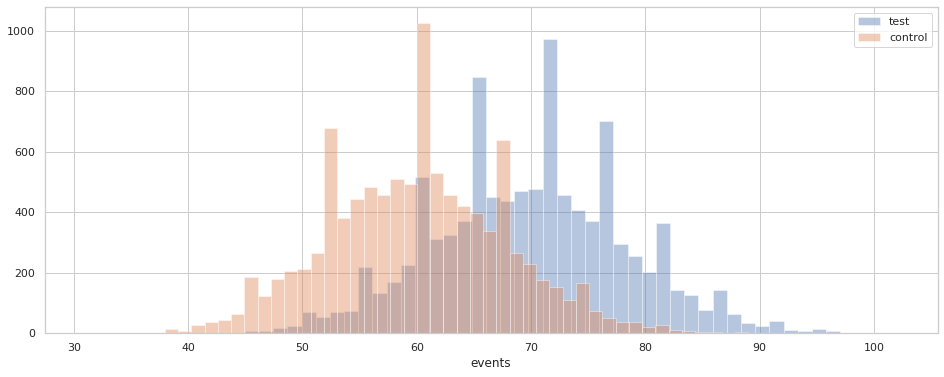

In [77]:
sns.distplot(task_2.query("segment == 'high' & group=='test'").events, label='test', kde=False)
sns.distplot(task_2.query("segment == 'high' & group=='control'").events, label='control', kde=False)
plt.legend()

Почти у цели – осталось выбрать формулу для модели. Напомним, что мы хотим проверить проверить эффект нескольких переменных – group и segment на events, с взаимодействием факторов.

Какую формулу используете?

- events ~ segment + group + segment:group'

Проведите тест (через anova_lm либо pg.anova), а затем используйте критерий Тьюки, чтобы понять между какими группами есть статистически значимые различия.

В данном случае для последующих сравнений между группами можно проделать следующую операцию: 

соединить колонки group и segment в combination, чтобы потом передать в аргумент groups в MultiComparison либо pairwise_tukey

In [78]:
model = smf.ols(formula = "events ~ segment + group + segment:group", data = task_2).fit() 
anova_lm(model, typ = 2)

,sum_sq,df,F,PR(>F)
segment,2.362480e+07,1.0,689756.377484,0.000000e+00
group,3.837195e+06,1.0,112031.864119,0.000000e+00
segment:group,3.664244e+04,1.0,1069.823273,2.060261e-233
Residual,3.424956e+06,99996.0,NaN,NaN


In [79]:
task_2['combination'] = task_2['group'] + ' \\ ' + task_2['segment']

In [80]:
pg.pairwise_tukey(data=task_2, dv="events", between="combination")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,control \ high,control \ low,59.970800,20.031575,39.939225,0.065432,610.391461,0.001,6.824282
1,control \ high,test \ high,59.970800,69.938500,-9.967700,0.082766,-120.432523,0.001,-1.703109
2,control \ high,test \ low,59.970800,33.025925,26.944875,0.065432,411.798717,0.001,4.603981
3,control \ low,test \ high,20.031575,69.938500,-49.906925,0.065432,-762.727892,0.001,-8.527429
4,control \ low,test \ low,20.031575,33.025925,-12.994350,0.041383,-314.002699,0.001,-2.220314
5,test \ high,test \ low,69.938500,33.025925,36.912575,0.065432,564.135148,0.001,6.307128


In [81]:
pg.anova(data=task_2, dv="events", between=['group','segment'])

,Source,SS,DF,MS,F,p-unc,np2
0,group,3.837195e+06,1.0,3.837195e+06,112031.864119,0.000000e+00,0.528383
1,segment,2.362480e+07,1.0,2.362480e+07,689756.377484,0.000000e+00,0.873383
2,group * segment,3.664244e+04,1.0,3.664244e+04,1069.823273,2.060261e-233,0.010585
3,Residual,3.424956e+06,99996.0,3.425093e+01,NaN,NaN,NaN


In [82]:
pairwise_tukeyhsd(task_2.events, task_2.combination).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
control \ high,control \ low,-39.9392,0.001,-40.1073,-39.7711,True
control \ high,test \ high,9.9677,0.001,9.7551,10.1803,True
control \ high,test \ low,-26.9449,0.001,-27.113,-26.7768,True
control \ low,test \ high,49.9069,0.001,49.7388,50.075,True
control \ low,test \ low,12.9944,0.001,12.888,13.1007,True
test \ high,test \ low,-36.9126,0.001,-37.0807,-36.7445,True


Визуализируйте результаты теста

Text(0, 0.5, 'Число покупок')

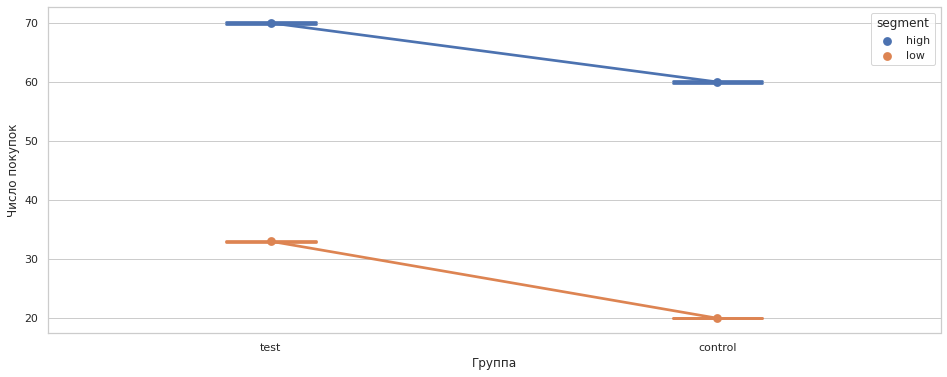

In [83]:
sns.pointplot(x = 'group', y = 'events', hue = 'segment', data = task_2, capsize = 0.2)
plt.xlabel('Группа')
plt.ylabel('Число покупок')


Text(0, 0.5, 'Число покупок')

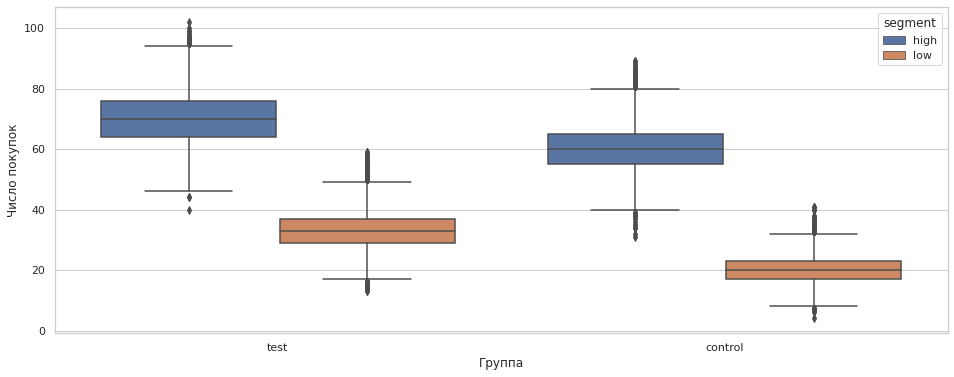

In [85]:
sns.boxplot(x = 'group', y = 'events', hue='segment', data = task_2)
plt.xlabel('Группа')
plt.ylabel('Число покупок')